<a href="https://colab.research.google.com/github/yhk775206/AIContents/blob/main/c_customLoad_%EC%9D%91%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable

from PIL import Image

## 1. train 데이터로 불러올 폴더 지정

In [3]:
# 네트워크에 들어갈 이미지 크기
#  ㄴ네트워크에는 동일한 크기의 이미지만 넣을 수 있음. 
#  ㄴGPU 병렬처리 때문
imgsize = 128  

In [4]:
# 폴더 이름
img_dir =  "drive/MyDrive/my_catdog/"  #"./images/"  # "../../images/cats/"

In [5]:
import os

"""
======================================================
MyGetInfoFromFolder
======================================================
* 폴더에서 클래스 관련 정보 추출
 - classes: 클래스 이름(=폴더명)
 - class_to_idx: { (클래스 이름): (인덱스) } 쌍
 - length: 폴더 내 모든 이미지 개수
 - total_file_list: 모든 이미지 파일의 경로 리스트
 - total_label: 모든 이미지의 라벨 리스트

* 양희경 함수- read_2path
"""
def MyGetInfoFromFolder(ipath):
  classes = sorted(os.listdir(ipath))
  class_to_idx = {}
  length = 0
  total_file_list=[]
  total_label=[]

  for i, c in enumerate(classes):  # class 폴더
    class_to_idx.update({c: i})

    file_list = sorted(os.listdir(ipath + "/" + c))
    length += len(file_list)

    for f in file_list:  # 이미지 파일 리스트
      total_file_list.append(ipath + c + "/" +f)
      total_label.append(i)

  return classes, class_to_idx, length, total_file_list, total_label

In [6]:
# MyGetInfoFromFolder 호출 테스트
classes, class_to_idx, length, total_file_list, total_label = MyGetInfoFromFolder(img_dir)
print(classes)
print(class_to_idx)
print(length)
print(total_file_list[0])
print(total_label[0])

['cats', 'dogs']
{'cats': 0, 'dogs': 1}
10
drive/MyDrive/my_catdog/cats/images (2).jpeg
0


In [25]:
"""
======================================================
CropImgSquare
======================================================
* 최대한 크게 정사각형으로 자르기
"""
# +최대한 크게 정사각형으로 자르기
def CropImgSquare(img):  
  # 단축 계산
  small_len = min(img.width, img.height)
  # 중심 계산
  cx, cy = img.width/2, img.height/2
  # 단축의 반 계산
  d = small_len/2

  # 구글링: PIL image / crop
  # (left, upper, right, lower) = (20, 20, 100, 100)
  (left, upper, right, lower) = (cx-d, cy-d, cx+d, cy+d)
  img = img.crop((left, upper, right, lower))

  return img

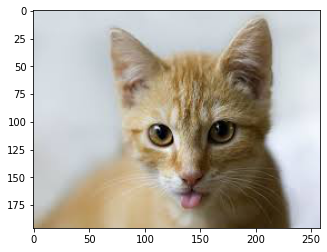

258 196


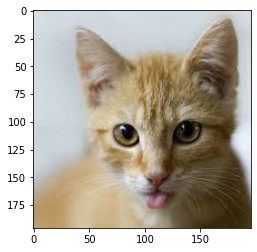

196 196


In [45]:
# CropImg 테스트
# 1. 원본 그리기
dir = img_dir + "cats/images (3).jpeg"
img = Image.open(dir)
plt.imshow(img)
plt.show()

print(img.width, img.height)

# 2. 자르고 그리기
img = CropImgSquare(img)

plt.imshow(img)
plt.show()

print(img.width, img.height)

In [46]:
"""
======================================================
MyGetInfoFromFolder
======================================================
* Custumized dataset
  폴더의 영상을 가져올 수 있는 클래스의 객체
  dset.ImageFolder 역할

* 입력 변수
   ipath: 데이터가 들어있는 경로
   ㄴ예) 'technique' or 'style' or 'artist_slug' or ...   
  imgsize: 기준이 되는 imgsize
    ㄴ주의: rescale의 최대 배수의 사이즈가 네트워크가 안터지는 최대 사이즈 이하여야 함

* 응용
  - 비율변경 없이 최대한 크게 정사각형으로 자르고, 크기 맞추기

* 양희경 클래스- Dataset_folder
"""
class MyImageFolder(Dataset):
  def __init__ (self, ipath,
                transform=transforms.ToTensor()):
    self.classes, self.class_to_idx, self.length, self.flist, self.labels = MyGetInfoFromFolder(ipath)
    
    self.root_dir = ipath    
    self.transform=transform
    
  def __len__(self):
    return self.length  # 이 path 에 있는 모든 폴더의 모든 이미지 개수

  def __getitem__(self, idx):     
    # original image
    img = Image.open(self.flist[idx])

    # 예외처리-mode 
    if (img.mode!="RGB"): 
      img = img.convert(mode="RGB")
    
    # +최대한 크게 정사각형으로 자르기
    img = CropImgSquare(img)

    # 이미지 조정
    img = self.transform(img)

    # 여러 정보를 출력하고 싶다면, 데이터 별로 tensor size 가 일정해야 함
    # 이미지 한장(256,256), 이미지 5장 리스트(256,256), 숫자 5개 리스트(5)
    #outimg = {'sample':sample_img, 'salImgs':bbx_imgs, 'salScores':salScores}

    # label
    label = self.labels[idx]

    return img, label

In [47]:
# Dataset_folder 호출 테스트
my_train = MyImageFolder(img_dir, 
                          transforms.Compose([transforms.Resize((imgsize, imgsize)),
                                              transforms.ToTensor()]
                                              ))

## 2. train 데이터 정보 출력해보기

In [48]:
nclass = len(my_train.classes)
print("# of classes(클래스 개수): %d" %nclass)

print("클래이 이름:", my_train.classes)
print("클래스별 인덱스:", my_train.class_to_idx)
print("my_train 개수:", my_train.__len__())

# of classes(클래스 개수): 2
클래이 이름: ['cats', 'dogs']
클래스별 인덱스: {'cats': 0, 'dogs': 1}
my_train 개수: 10


## 3. train 데이터 그려보기

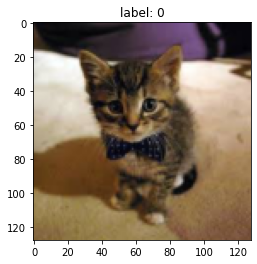

torch.Size([128, 128, 3])


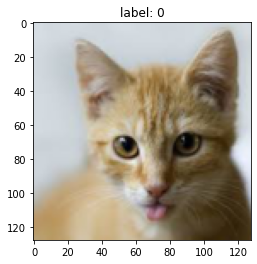

torch.Size([128, 128, 3])


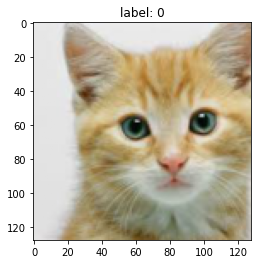

torch.Size([128, 128, 3])


In [49]:
for i in range(3):
  img = my_train[i][0]  #.numpy()  # image 타입을 numpy 로 변환 (3, width, height)    
  img = np.transpose(img, (1, 2, 0)) # (3, width, height) -> (width, height, 3)

  plt.title("label: %d" %my_train[i][1] )
  plt.imshow(img)
  plt.show()

  print(img.shape)  #print(img.size)

## 4. 데이터 로드하기
학습시킬 때 batch_size 단위 묶음으로 로드하기 위함

In [51]:
batch_size= 3

In [52]:
train_loader = data.DataLoader(my_train, batch_size=batch_size,
                            shuffle=False, num_workers=2,
                            drop_last=True)  # batch_size 만큼 나눌 때 나머지는 버려라

## 5. 데이터 로더 사용하기

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff1b695b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff1b695b00>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

[0]
한 번에 로드되는 데이터 크기: 3
torch.Size([3, 3, 128, 128])
torch.Size([3])


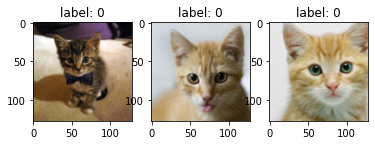

[1]
한 번에 로드되는 데이터 크기: 3
torch.Size([3, 3, 128, 128])
torch.Size([3])


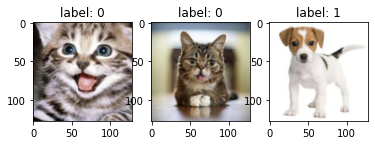

[2]
한 번에 로드되는 데이터 크기: 3
torch.Size([3, 3, 128, 128])
torch.Size([3])


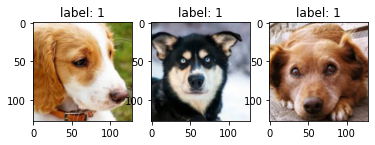

In [55]:
n = 3  # 샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(train_loader):  # batch_size 만큼
    if i>5:
        break
        
    print ("[%d]" %i)
    print ("한 번에 로드되는 데이터 크기:", len(imgs))
    
    # GPU 에 로드되기 위함. 만약 CPU로 설정되어 있다면 자동으로(?) CPU로 로드됨
    x = Variable(imgs)#.cuda()     # (batch_size, 3, 28, 28)
    y_ = Variable(labels)#.cuda()  # (batch_size)
    
    print(x.shape)
    print(y_.shape)
    
    # 그리기
    for j in range(n):
        img = imgs[j].numpy()  # image 타입을 numpy 로 변환 (3, width, height)    
        img = np.transpose(img, (1, 2, 0)) # (3, width, height) -> (width, height, 3)
        
        plt.subplot(1, n, j+1)  # (1,3) 형태 플랏의 j 번째 자리에 그리겠다
        plt.imshow(img) #, cmap='gray')
        plt.title("label: %d" %labels[j] )        
    plt.show()